## Практическое задание
Вариант 1. (простой)

обучить сверточную нейронную сеть в стиле AlexNet (с падением размера ядра свертки и последовательностью блоков свертка-пулинг (conv-pool)-(conv-pool)-...) на датасете fashion-mnist или cifar10
оценить рост точности при увеличении ширины сети (больше ядер)
оценить рост точности при увеличении глубины сети (больше слоев)
(опциционально)сравнить с точностью полносвязной сети для этой выборки
Вариант 2. (сложный)

реализовать нейронную сеть или стек из сверток (Concatenate) на сifar10.
оценить рост точности при увеличении ширины сети (больше ядер), больше нитей.
оценить рост точности при увеличении глубины сети (больше слоев)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from __future__ import print_function
#import tensorflow.keras as keras # расскоментируйте эту строку, чтобы начать обучение
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, AveragePooling2D
from tensorflow.keras.utils import plot_model, to_categorical 
from tensorflow.keras.applications import vgg16

import os

In [2]:
classes=['самолет', 'автомобиль', 'птица', 'кот', 'олень', 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик']

In [3]:
# установка параметров нейросети
batch_size = 128
num_classes = 10
epochs = 15
data_augmentation = False
num_predictions = 20
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

# разделение тренировочной и тестовой выборки
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'тренировочные примеры')
print(x_test.shape[0], 'тестовые примеры')

# преобразование матрицы чисел 0-9 в бинарную матрицу чисел 0-1
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)


x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

170508288/170498071 [==============================] - 2s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 тренировочные примеры
10000 тестовые примеры


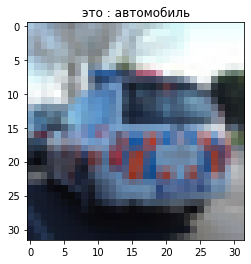

In [4]:
N = 1131

plt.imshow(x_test[N][:,:,:])
plt.title('это : '+classes[np.argmax(y_test[N,:])])
plt.show()

In [5]:
def Inception_Module(input, filter_1x1, filter_3x3_reduce,
                    filter_3x3, filter_5x5_reduce, filter_5x5, filter_pool_proj):
       conv_1x1 = Conv2D(filters=filter_1x1, kernel_size=1, padding='same',
                                   activation='relu')(input)
 
       conv_3x3_reduce = Conv2D(filters=filter_3x3_reduce, kernel_size=1, padding='same',
                                          activation='relu')(input)
       conv_3x3 = Conv2D(filters=filter_3x3, kernel_size=3, padding='same',
                                   activation='relu')(conv_3x3_reduce)
 
       conv_5x5_reduce = Conv2D(filters=filter_5x5_reduce, kernel_size=1, padding='same',
                                          activation='relu')(input)
       conv_5x5 = Conv2D(filters=filter_5x5, kernel_size=5, padding='same',
                                   activation='relu')(conv_5x5_reduce)
 
       maxpool = MaxPooling2D(pool_size=3, strides=1, padding='same')(input)
       maxpool_proj = Conv2D(filters=filter_pool_proj, kernel_size=1, padding='same',
                                       activation='relu')(maxpool)
       inception_output = Concatenate(axis=-1)([conv_1x1, conv_3x3, conv_5x5, maxpool_proj])
       return inception_output

In [6]:
input= Input(shape=[32, 32, 3])
# сверточные слои
conv1 = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu')(input)
conv2 = Conv2D(filters=192, kernel_size=(3, 3), strides=(1, 1), activation='relu')(conv1)

# пуллинговый слой
maxpool1 = MaxPooling2D(pool_size=(2, 2))(conv2)

# inception слой
inception1 = Inception_Module(maxpool1, 64, 96, 128, 16, 32, 32)

# пуллинговый слой
maxpool2 = MaxPooling2D(pool_size=(2, 2))(inception1)

# inception слой
inception2 = Inception_Module(maxpool2, 192, 96, 208, 16, 48, 64)

# пуллинговый слой
avrpool = AveragePooling2D(pool_size=(7, 7))(inception2)

# dropout 
drop_out = Dropout(rate=0.4)(avrpool)

# сглаживание CNN выхода чтобы можно было его присоединить к полносвязногому слою
flatten_layer = Flatten()(drop_out)

# полносвязный слой
out = Dense(num_classes, activation='softmax')(flatten_layer)

# Соберем полную модель сети от входа к выходу 
model = Model(inputs = input, outputs = out) 

# компиляция модели
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])



if not data_augmentation:
    print('Не используется data augmentation')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Использование data augmentation в реальном времени')
    # Препроцессинг и data augmentation в реальном времени:
    datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False, 
        zca_epsilon=1e-06, 
        rotation_range=5, 
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0., 
        zoom_range=0., 
        channel_shift_range=0.,
        fill_mode='nearest',
        cval=0.,
        horizontal_flip=True,
        vertical_flip=False,
        rescale=None,
        preprocessing_function=None,
        data_format=None,
        validation_split=0.2)

    # запуск data augmentation через fit
    #datagen.fit(x_train)

    # запуск data augmentation через fit_generator
    model.fit_generator(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        workers=-1)

# сохранение модели и весов
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('сохранить обученную модель как %s ' % model_path)

# проверка работы обученной модели
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])


Не используется data augmentation
Epoch 1/15
391/391 [==============================] - 45s 87ms/step - loss: 1.7432 - accuracy: 0.3394 - val_loss: 1.4155 - val_accuracy: 0.4886
Epoch 2/15
391/391 [==============================] - 33s 84ms/step - loss: 1.2949 - accuracy: 0.5296 - val_loss: 1.1537 - val_accuracy: 0.5903
Epoch 3/15
391/391 [==============================] - 33s 84ms/step - loss: 1.0806 - accuracy: 0.6152 - val_loss: 0.9972 - val_accuracy: 0.6329
Epoch 4/15
391/391 [==============================] - 33s 83ms/step - loss: 0.9635 - accuracy: 0.6579 - val_loss: 0.9050 - val_accuracy: 0.6818
Epoch 5/15
391/391 [==============================] - 32s 83ms/step - loss: 0.8790 - accuracy: 0.6893 - val_loss: 0.8293 - val_accuracy: 0.7079
Epoch 6/15
391/391 [==============================] - 33s 83ms/step - loss: 0.8119 - accuracy: 0.7159 - val_loss: 0.7714 - val_accuracy: 0.7314
Epoch 7/15
391/391 [==============================] - 32s 83ms/step - loss: 0.7438 - accuracy: 0.7394 

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 30, 30, 64)   1792        ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 28, 28, 192)  110784      ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 14, 14, 192)  0           ['conv2d_1[0][0]']               
                                                                                              

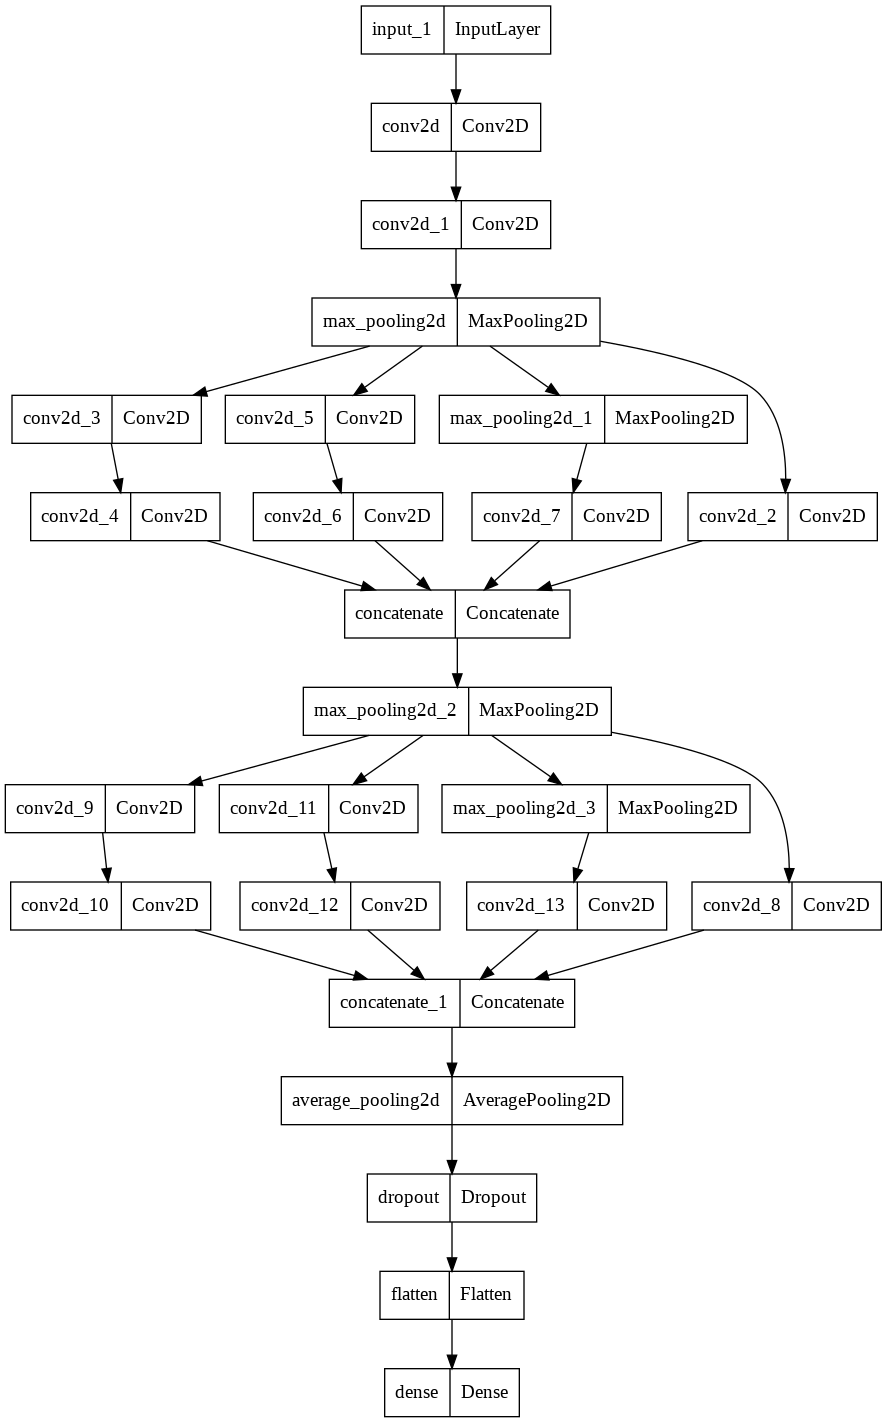

In [8]:
plot_model(model,'model_sconv.png')

Что вернет ImageDataGenerator

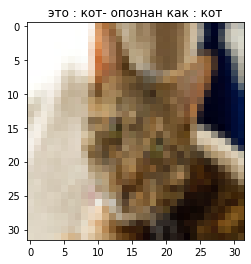

In [11]:
N = 103
y_p=model.predict(x_test[N:N+1][:,:,:])
y_t = np.argmax(y_test[N:N+1], axis = 1 )
y_i = np.argmax(y_p, axis = 1 )
plt.imshow(x_test[N][:,:,:])
plt.title('это : '+classes[y_t[0]]+'- опознан как : '+classes[y_i[0]])
plt.show()

Попробовал подогнать часть архитектуры GoogleNet под нашу задачу. Результат вышел не самый высокий, но в целом выше чем было ранее.